### Clustertechniques used for examscores, Financial data and pseudorandom data.
techniques used: 
- K-nearest neighbours
- K-Means

In [ ]:
import numpy as np
import math
from matplotlib import pyplot as plt
import pandas as pd 
import itertools
import seaborn as sns 
from scipy import stats
from scipy import linalg as la 
from mpl_toolkits.mplot3d import Axes3D

In [27]:
examns = pd.read_csv("Data\examns.csv")
examns.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86


When training a kNN classifier, it's essential to **normalize** the features. This is because kNN measures the distance between points.

We should normalize the data after splitting it into training and test sets. This is to prevent **‘data leakage’** as the normalization would give the model additional information about the test set if we normalized all the data at once.

In [9]:
training = examns.sample(frac=0.75, random_state=1)
test = examns.drop(training.index)

# check that the two subframes combined equal the original dataframe
assert len(examns) == len(test) + len(training)
assert examns.index.equals(training.index.union(test.index))
#no assertion error

training["math_z"] = stats.zscore(training["math score"])
training["read_z"] = stats.zscore(training["reading score"])

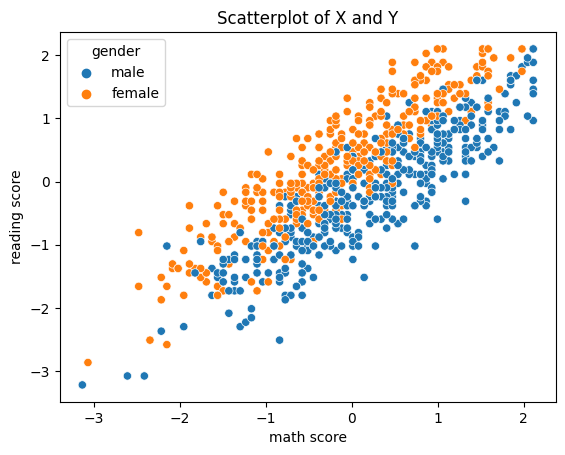

In [10]:
#sns.scatterplot(data=training, x='math score', y='reading score', hue='gender')
sns.scatterplot(data=training, x='math_z', y='read_z', hue='gender')

plt.title('Scatterplot of X and Y')
plt.xlabel('math score')
plt.ylabel('reading score')

plt.show()

In [11]:
print(training.gender.value_counts())

male      398
female    352
Name: gender, dtype: int64


N Data points with M feautures: $\begin{pmatrix} math \\ read \end{pmatrix}$. 
<br>
Two groups, with two feautures. The Size of both groups is fairly equal, meaning, we dont have to worry about **Strong biases** towards one group (especially for larger K) 
<br>
- 'uniform' : uniform weights.  All points in each neighborhood
          are weighted equally.
- 'distance' : weight points by the inverse of their distance.
          in this case, closer neighbors of a query point will have a
          greater influence than neighbors which are further away.
- [callable] : a user-defined function which accepts an
          array of distances, and returns an array of the same shape
          containing the weights.

## KNN Using SciPy 

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

In [7]:
examns = pd.read_csv("Data\examns.csv")
fun = lambda y: 1 if y == "male" else 0 #important for later functioncalls 
examns.gender = examns.gender.apply(fun)
examns.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,0,group D,some college,standard,completed,59,70,78
1,1,group D,associate's degree,standard,none,96,93,87
2,0,group D,some college,free/reduced,none,57,76,77
3,1,group B,some college,free/reduced,none,70,70,63
4,0,group D,associate's degree,standard,none,83,85,86


In [8]:
x_train, x_test, y_train, y_test = train_test_split(examns[["math score", "reading score"]],examns["gender"],
                                                    test_size=0.25)
knn = KNeighborsClassifier(n_neighbors=3)
classifier = knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)
#print(knn.predict_proba(x_test)) #Matrix of probs, according to number of neighbors  

accuracy = knn.score(x_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.764


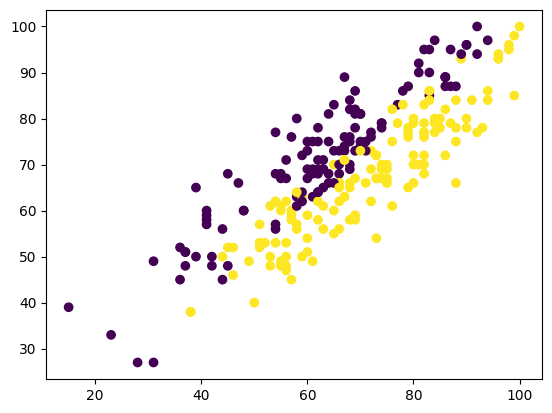

In [9]:
plt.scatter(x_test["math score"],x_test["reading score"], c = y_pred)
#plt.legend()
plt.show()

We now can tune our parameters and Perform Cross-validation, to find the K that fits the data best (i.e. has the highest accuracy) 
<br>
- Large K: resource issues, high bias - small variance
- small K: fast, high variance - small bias 
<br>
<br>
sqrt(n) is often a sensible guess 

<br>
For binary features, one commonly used distance metric is the Hamming distance, which measures the number of positions in which two binary vectors differ.

Text(0, 0.5, 'Accuracy Score')

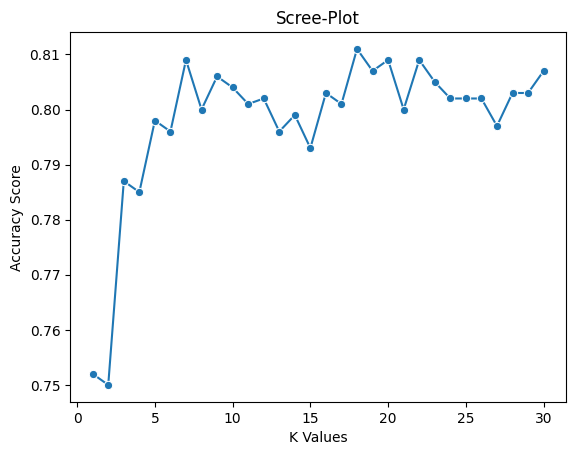

In [95]:
k_values = [i for i in range (1,31)]
scores = []

scaler = StandardScaler()
X = scaler.fit_transform(examns[["math score", "reading score"]])

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, examns[["math score", "reading score"]], examns.gender, cv=5) 
    # cv = 5: 5 equall groups, 4 train and one to test. 
    scores.append(np.mean(score)) # appends the average of 5 Scores 
    
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.title("Scree-Plot")
plt.ylabel("Accuracy Score")

**kNN** can also be used in a Regresioncontext, where the Predictor is a numeric variable 

In [11]:
examns[["math score", "reading score", "writing score"]].corr()

,math score,reading score,writing score
math score,1.000000,0.811767,0.790055
reading score,0.811767,1.000000,0.948909
writing score,0.790055,0.948909,1.000000


In [12]:
x_train, x_test, y_train, y_test = train_test_split(examns[["math score", "reading score"]],examns["writing score"],
                                                    test_size=0.25)
knn = KNeighborsClassifier(n_neighbors=7)
classifier = knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)
print(sum(y_pred - y_test)**2)

498436


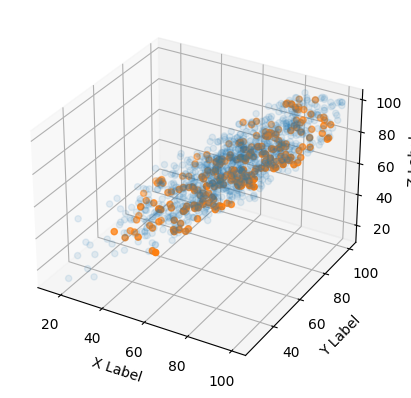

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(examns["math score"], examns["reading score"], examns["writing score"], alpha = 0.1)
ax.scatter(x_test["math score"], x_test["reading score"], y_pred)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

# K-Means Clustering 

In [93]:
from sklearn.datasets import make_blobs
from scipy.spatial import Voronoi, voronoi_plot_2d

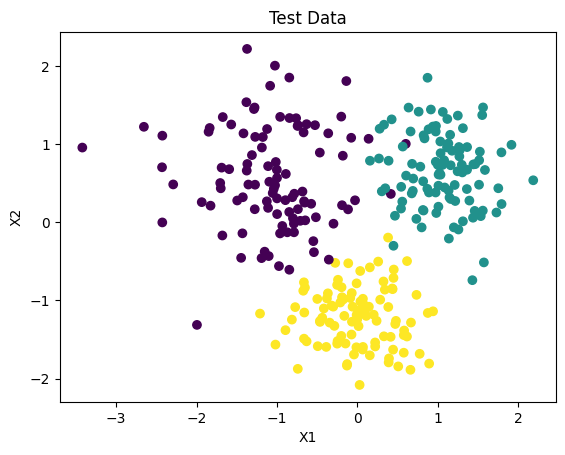

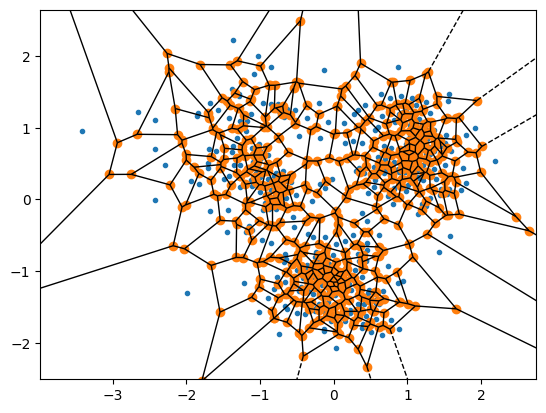

In [94]:
# Generate random data with 3 clusters
x, y = make_blobs(n_samples=300, centers=[[0,0],
                                          [1,0],
                                          [0.5,-0.75]],
                  cluster_std=[0.3, 0.2, 0.2], center_box=(-2,2), random_state=6)

x = scaler.fit_transform(x)
vor = Voronoi(x)

# x.shape = (300,2)
# y = [0,1,2,0,0,2,0,1,0,...]
plt.scatter(x[:, 0], x[:, 1], c=y)
#plt.scatter(centroids[:, 0], centroids[:, 1], c="pink")
plt.title("Test Data")
plt.xlabel("X1")
plt.ylabel("X2")
fig = voronoi_plot_2d(vor)
plt.show()

In [20]:
# Start with a random guess, based on sample data 
centroids = np.random.randn(3, 2) * np.array([np.std(i) for i in x.T]) + [np.mean(i) for i in x.T]
centroids

array([[ 0.49537339,  0.93427632],
       [-1.51420114,  0.97542475],
       [ 1.96103792, -1.43809991]])

In [21]:
def kMeans(x,k,max_iters = 100, tol = 0.01):
    distances = np.empty((x.shape[0], k))
    centroids = np.random.randn(3, 2) * np.array([np.std(i) for i in x.T]) + [np.mean(i) for i in x.T]
    EPS = [float('-inf')]
    while max_iters:
        for i in range(k):
            cent = centroids[i,:]
            dist = lambda row: la.norm(cent - row,2)
            distances[:,i] = np.apply_along_axis(dist, axis=1, arr=x)

        labels = np.argmin(distances, axis=1)

        cur = np.array([np.mean(x[labels == j], axis=0) for j in range(k)])
        eps = abs(cur - centroids)
        EPS.append(np.sum(eps))
      
        if EPS[-1] <= EPS[-2]:
            print("Converged")
            return labels, centroids
            
#     for j in range(k):
#         centroids[j] = np.mean(x[labels == j], axis=0)


    return labels, centroids

Converged


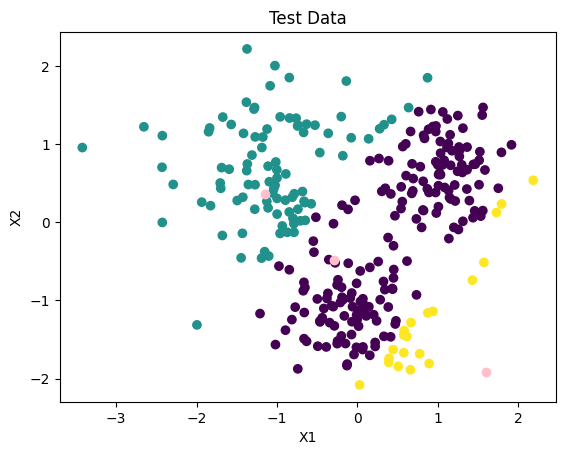

In [23]:
labels, centroids = kMeans(x,3,max_iters = 1000, tol = 0.01)
plt.scatter(x[:, 0], x[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], c="pink")
plt.title("Test Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

We notice a heavy **dependence** on the initial position of the Centroids. So multiple runs with different Seeds are recommended. 

# KMC using SciPY

**You should refer to Yahoo!'s terms of use (here, here, and here) for details on your rights to use the actual data downloaded. Remember - the Yahoo! finance API is intended for personal use only.**

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [1]:
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.cluster import KMeans

In [2]:
now = datetime.now()
one_day_before = now - timedelta(days=1)
date_string = one_day_before.strftime("%Y-%m-%d")

ticker = "^GSPC"
data = yf.download(ticker, start="2006-01-01", end=date_string)

[*********************100%***********************]  1 of 1 completed


In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,1248.290039,1270.219971,1245.739990,1268.800049,1268.800049,2554570000
2006-01-04,1268.800049,1275.369995,1267.739990,1273.459961,1273.459961,2515330000
2006-01-05,1273.459961,1276.910034,1270.300049,1273.479980,1273.479980,2433340000
2006-01-06,1273.479980,1286.089966,1273.479980,1285.449951,1285.449951,2446560000
2006-01-09,1285.449951,1290.780029,1284.819946,1290.150024,1290.150024,2301490000


In [4]:
data["Spread"] = data.High - data.Low
data["Spread_smooth"] = data["Spread"].ewm(span=30).mean()

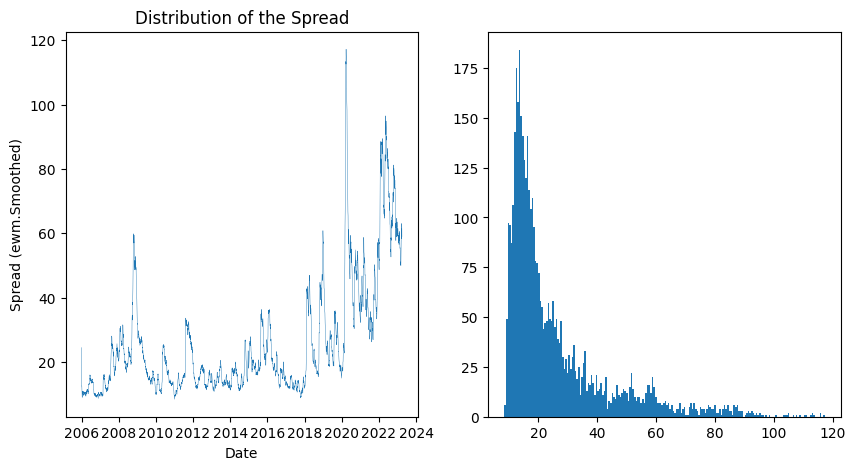

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


ax1.plot(data.index, data['Spread_smooth'], linewidth = 0.3)
ax1.set_xlabel('Date')
ax1.set_ylabel('Spread (ewm.Smoothed)')
ax1.set_title('Historical Data for S&P 500 Index')

ax2.hist(data['Spread_smooth'], bins = 200)
ax1.set_title('Distribution of the Spread')

plt.show()

In [39]:
# Create KMeans object with 3 clusters
kmeans = KMeans(n_clusters=3)
# Reshape data to 2D array with one column
X = data.Spread_smooth.values.reshape(-1, 1)

# Fit KMeans object to data
kmeans.fit(X)

centers = kmeans.cluster_centers_
data['Cluster'] = kmeans.labels_

c:\users\zogaj\pycharmprojects\ml\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


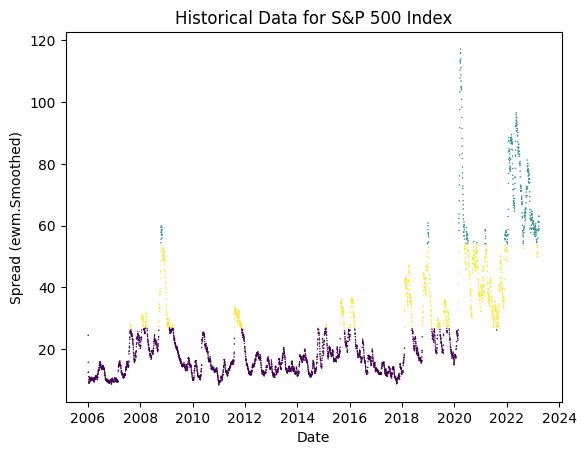

In [36]:
plt.scatter(data.index, data['Spread_smooth'], c = kmeans.labels_ , s=0.5, linewidths=0.3)
#plt.axhline(kmeans.cluster_centers_)
plt.xlabel('Date')
plt.ylabel('Spread (ewm.Smoothed)')
plt.title('Historical Data for S&P 500 Index')
plt.show()

In [52]:
print("Frequencies x means")
np.array([np.array(data.Cluster.value_counts(), dtype = int),
          centers.reshape(-1)])

array([[3063.        ,  880.        ,  395.        ],
       [  38.32026487,   16.43087677,   71.58034945]])

In [90]:
def jump_probs(x, delta = 30):
    eta = data.Cluster.unique()
    idx = {j:i for i,j in enumerate(eta)}
    matr = np.zeros((len(eta),len(eta)))
    
    for i, clust in enumerate(x[:len(x)-delta]):
        # clust: dict.key()
        ridx = idx[clust] #from
        cidx = idx[x[i+delta]] #to 
        matr[ridx,cidx] += 1 
        
    row_sums = np.sum(matr, axis=1)
    row_prob_table = np.divide(matr, row_sums)

    return row_prob_table
        

Estimate the Probabilities from jumping from _(y)_ one cluster to the other _(x)_.

In [91]:
jp = jump_probs(data.Cluster,10)
x_labels = ['C1', 'C2', 'C3']
y_labels = ['C1', 'C2', 'C3']
pd.DataFrame(jp, columns=y_labels, index=x_labels)

,C1,C2,C3
C1,0.956579,0.145455,0.012987
C2,0.040157,0.780682,0.181818
C3,0.000000,0.073864,0.831169
